### This is a quick prototype for creating multi-panel graphics, such as for ensemble forecasts.  It combines an old Notebook for examinging grib2 files with some online examples for setting up subplots.

### This sample uses a set of forecast hours from a single deterministic run rather than a set of ensemble members.

In [1]:
# many of these are not needed, just what was in the old Notebook.

import matplotlib.pyplot as plt

from os.path import exists

import argparse
import adb_graphics.specs as specs
from importlib import reload
import abc
import datetime
from functools import lru_cache
from string import digits, ascii_letters

from matplotlib import cm
import numpy as np
import xarray as xr
from mpl_toolkits.basemap import Basemap
from metpy.plots import ctables

In [2]:
# some methods that would be in other parts of the pygraf repository

def latlons():

    ''' Returns the set of latitudes and longitudes '''

    coords = sorted([c for c in list(ds.coords) if
                     any(ele in c for ele in ['lat', 'lon'])])
    return [ds.coords[c].values for c in coords]

    
def corners() -> list:

    '''
    Returns lat and lon of lower left (ll) and upper right(ur) corners:
           ll_lat, ur_lat, ll_lon, ur_lon
    '''

    lat, lon = latlons()
    return [lat[0, 0], lat[-1, -1], lon[0, 0], lon[-1, -1]]

In [3]:
# these are from the default_specs file, so would be read in as **kwargs, etc.

clevs = np.arange(5, 76, 5)
cmap = "NWSReflectivity"
colors = "cref_colors"
ncl_name = "REFD_P0_L103_GLL0"
ticks = 5
title = "1 km agl Reflectivity"
unit = "dBZ"
cdate = "11 Feb 2022"
chour = "09Z"

In [4]:
# likewise, pulled these in  from the specs.py file for reflectivity

ncolors = len(clevs)-1
grays = cm.get_cmap('Greys', 5)([0])
nws = ctables.colortables.get_colortable(cmap)(range(ncolors))
white = cm.get_cmap('Greys', 5)([0])
colors = np.concatenate((grays, nws, white))

### I think there are two ways to match the subplots and ensemble members:  1. loop through the subplots and determine the proper member, or 2. loop through the members and find the correct subplot for each.

### Here I used the former method, the following line sets the ensemble member for each subplot index.  99 and 999 represeent the top and bottom left subplot areas which don't have an ensemble member.

### currently pointing to the real time runs, so need to update path whenever the data ages off ther system, or copy some test files.

In [5]:
panel_indices = [99, 1, 2, 3, 0, 4, 5, 6, 999, 7, 8, 9]

row_ind: 0    col_ind: 0   index: 0
row_ind: 0    col_ind: 1   index: 1
row_ind: 0    col_ind: 2   index: 2
row_ind: 0    col_ind: 3   index: 3
row_ind: 1    col_ind: 0   index: 4
row_ind: 1    col_ind: 1   index: 5
row_ind: 1    col_ind: 2   index: 6
row_ind: 1    col_ind: 3   index: 7
row_ind: 2    col_ind: 0   index: 8
row_ind: 2    col_ind: 1   index: 9
row_ind: 2    col_ind: 2   index: 10
row_ind: 2    col_ind: 3   index: 11


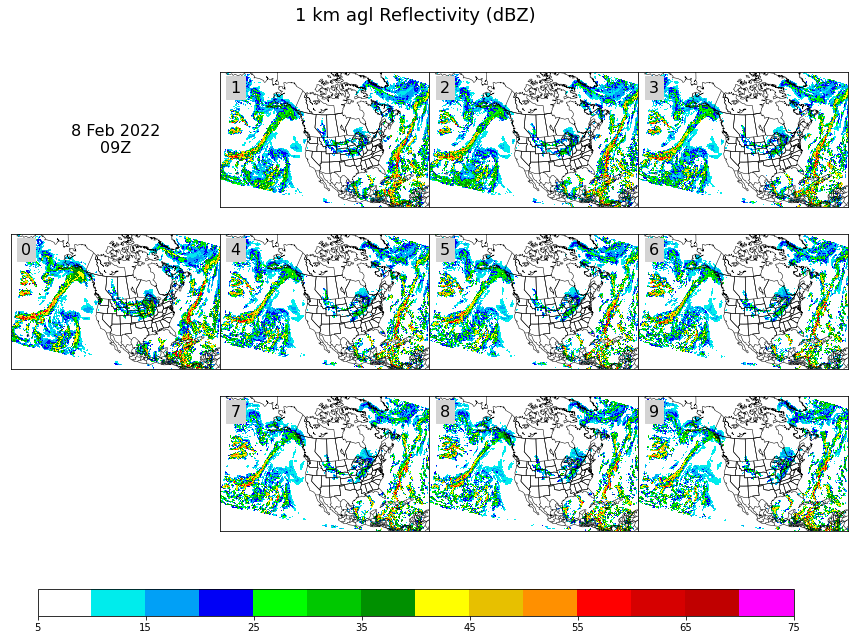

In [20]:
# set up the subplot scheme, with axes providing the needed coords for each subplot.
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 9))

# loop through the subplots, by row
for row_ind in range(3):
    for col_ind in range(4):
        index = row_ind*4+col_ind
        current_ax = axes[row_ind, col_ind] # use coordinates for the current index
        print("row_ind: {0}    col_ind: {1}   index: {2}".format(row_ind, col_ind, index))
        
        gfile = "/lfs4/BMC/nrtrr/NCO_dirs/ptmp/com/RRFS_NA_3km/para/RRFS_NA_3km_dev1.20220211/09/RRFS_NA_3km.t09z.bgdawpf"+str(panel_indices[index]).zfill(3)+".tm00.grib2"

# three checks for missing data:
# 1. top left - print datetime in the box
# 2. bottom left - leave blank
# 3. missing ensemble file - print a message
# For all three cases, don't pllot the axes box, and continue to the top of the loop
        if not exists(gfile):
            if panel_indices[index] == 99:
                current_ax.text(0.5, 0.5, cdate+"\n"+chour, fontsize=16, horizontalalignment='center',
                                verticalalignment='center', transform=current_ax.transAxes)
                current_ax.axis("off")
                continue
            elif panel_indices[index] == 999:
                current_ax.axis("off")
                continue
            else:
                current_ax.text(0.5, 0.5, 'Not\nAvailable', fontsize=16, color="Blue",
                                horizontalalignment='center', verticalalignment='center',
                                transform=current_ax.transAxes)
                current_ax.axis("off")
                continue

# open the file and set variables (only reads in refl_c, below)
        ds = xr.open_dataset(gfile, engine='pynio', lock=False, backend_kwargs=dict(format="grib2"),)

        grid = "GRLL0" # RRFS NA
#        grid = "GLC0"  # HRRR CONUS (and RRFS cut out)
        temp_sfc = ds.get('TMP_P0_L1_'+grid)
        ulwrf_sfc = ds.get('ULWRF_P0_L1_'+grid)
        ulwrf_toa = ds.get('ULWRF_P0_L8_'+grid)
        refl_c = ds.get('REFC_P0_L200_'+grid)
        field = ds['TMP_P0_2L108_'+grid].sel({'lv_SPDL5': 2})

# set up to get the plotting domain and parms for NA grid,
# I started to set up an option for CONUS but didn't make any progress
        lat = ds['gridlat_0']
        grid_info = {}
        grid_info['projection'] = 'rotpole'

        # CenterLon in RAP and Longitude_of_southern_pole in RRFS
        lon_0 = lat.attrs.get('CenterLon', lat.attrs['Longitude_of_southern_pole'])
        grid_info['lon_0'] = lon_0[0] - 360
        grid_info['lon_0'] = 248 - 360

        # CenterLat in RAP and Latitude_of_southern_pole in RRFS

        # RAP 254, 54 (90 - centerlat == 90 - 54 == 36)
        # RRFS 254, -36
        # RRFS NA 3, 248, -42
        center_lat = lat.attrs.get('CenterLat', lat.attrs['Latitude_of_southern_pole'])
        grid_info['o_lat_p'] = - center_lat[0]
        grid_info['o_lat_p'] = 42

        grid_info['o_lon_p'] = - 180

        if corners() is not None:
            grid_info.update(dict(
                llcrnrlat=corners()[0],
                llcrnrlon=corners()[2],
                urcrnrlat=corners()[1],
                urcrnrlon=corners()[3],
                ))

# plot basemap
        m = Basemap(**grid_info, ax=current_ax)
        x, y = m(ds.coords['gridlon_0'].values, ds.coords['gridlat_0'].values)

        try:
            m.drawcoastlines(linewidth=0.5)
        except ValueError:
            m.drawcounties(color='k',
                                linewidth=0.4,
                                zorder=2,
                                )

        m.drawstates() 
        m.drawcountries()

# plot contour and add a small box for the ensemble member number
        contour = m.contourf(x, y, refl_c, levels=clevs, colors=colors)
        current_ax.text(0.05, 0.85, str(panel_indices[index]), fontsize=16, backgroundcolor="lightgrey", transform=current_ax.transAxes)

# once all the subplots are ready, adjust to remove white space and make room for color bar
plt.subplots_adjust(bottom=0.15, top=0.90, wspace=0, hspace=0)
# add the color bar (based on last contour, but all should be the same)
cax = plt.axes([0.15, 0.040, 0.70, 0.041])
plt.colorbar(contour, orientation='horizontal', cax=cax)

# plot title
fig.suptitle(f'{title} ({unit})', fontsize=18)
plt.show()